Installing required libraries

In [ ]:
# For mitigation

!pip install tensorflow-text -q
!pip install einops -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 16.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.16.1'

In [ ]:
import tensorflow_text as tf_text

In [ ]:
# For mitigation

import numpy as np

import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
# For detection

import pandas as pd # read the csv
import re # regex to detect username, url, html entity
import nltk # to use word tokenize (split the sentence into words)
from nltk.corpus import stopwords # to remove the stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from keras.utils import to_categorical
from keras import backend as K

# Detection

In [ ]:
import pandas as pd

filtered_df = pd.read_csv('/content/filtered_file.csv')

print(filtered_df)

       class                                              tweet
0          1  !!! RT @mayasolovely: As a woman you shouldn't...
1          0  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2          0  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3          0  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4          0  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...      ...                                                ...
31347      1         @HollyYM Congratulations and well done!  x
31348      1   &quot;Wow, What A Tight Fit&quot; Lmao, Shutup. 
31349      1  @theokk don't know what you could possibly mea...
31350      1  @shwood loved the cameo, made me chuckle! alon...
31351      1  lol. i just realized my room has a color theme...

[31352 rows x 2 columns]


In [ ]:
filtered_df

,class,tweet
0,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
31347,1,@HollyYM Congratulations and well done! x
31348,1,"&quot;Wow, What A Tight Fit&quot; Lmao, Shutup."
31349,1,@theokk don't know what you could possibly mea...
31350,1,"@shwood loved the cameo, made me chuckle! alon..."


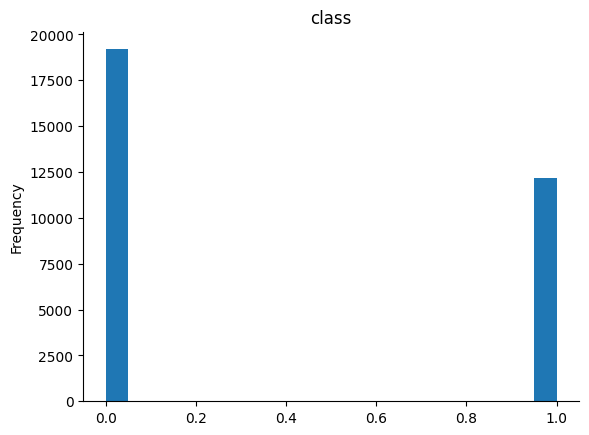

In [ ]:
from matplotlib import pyplot as plt
filtered_df['class'].plot(kind='hist', bins=20, title='class')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
 # Save the filtered DataFrame back to a CSV file
filtered_df.to_csv('filtered_file.csv', index=False)

In [ ]:
filtered_df

,class,tweet
0,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
31347,1,@HollyYM Congratulations and well done! x
31348,1,"&quot;Wow, What A Tight Fit&quot; Lmao, Shutup."
31349,1,@theokk don't know what you could possibly mea...
31350,1,"@shwood loved the cameo, made me chuckle! alon..."


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
tweet = list(filtered_df['tweet'])
labels = list(filtered_df['class'])

In [ ]:
stop_words = set(stopwords.words('english'))

# add rt to remove retweet in dataset (noise)
stop_words.add("rt")

# remove html entity:
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# change the user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "user", raw_text)

    return text

def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)

    return text

# remove unnecessary symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')

    return text

# remove stopwords
def remove_stopwords(raw_text):
    tokenize = nltk.word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = " ".join(text)

    return text

def preprocess(datas):
    clean = []
    # change the @xxx into "user"
    clean = [change_user(text) for text in datas]
    # remove emojis (specifically unicode emojis)
    clean = [remove_entity(text) for text in clean]
    # remove urls
    clean = [remove_url(text) for text in clean]
    # remove trailing stuff
    clean = [remove_noise_symbols(text) for text in clean]
    # remove stopwords
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
clean_tweet = preprocess(tweet)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clean_tweet, labels, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()

# build the vocabulary based on train dataset
tokenizer.fit_on_texts(X_train)

# tokenize the train and test dataset
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# vocabulary size (num of unique words) -> will be used in embedding layer
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
max_length = max(len(seq) for seq in X_train)

# to test an outlier case (if one of the test dataset has longer length)
for x in X_test:
    if len(x) > max_length:
        print(f"an outlier detected: {x}")

X_train = pad_sequences(X_train, maxlen = max_length)
X_test = pad_sequences(X_test, maxlen = max_length)

In [ ]:
y_test = to_categorical(y_test, num_classes=2)
y_train = to_categorical(y_train, num_classes=2)

In [ ]:
print(f"num test tweet: {y_test.shape[0]}")
print(f"num train tweet: {y_train.shape[0]}")

num test tweet: 6271
num train tweet: 25081


In [ ]:
# Custom metrics

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2 * ((precisions * recalls) / (precisions + recalls + tf.keras.backend.epsilon()))


In [ ]:
output_dim = 200

In [ ]:
# LSTM model architechture (CNN + LSTM)

detect_model = Sequential([

    # embedding layer is like idk
    # Embedding(vocab_size, output_dim, input_length=max_length),
    Embedding(vocab_size, output_dim),

    # lstm for xxx
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),

    # dropout to prevent overfitting
    Dropout(0.5),

    # dense to connect the previous output with current layer
    Dense(128, activation="relu"),

    # dropout to prevent overfitting
    Dropout(0.5),

    # this is output layer, with 3 class (0, 1, 2)
    Dense(2, activation="softmax"),
])

In [ ]:
detect_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1,precision, recall])

In [ ]:
detect_model_history = detect_model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs=8,
    validation_data=(X_test, y_test)
)

Epoch 1/8
392/392 ━━━━━━━━━━━━━━━━━━━━ 81s 176ms/step - accuracy: 0.8060 - f1: 0.8060 - loss: 0.3619 - precision: 0.8060 - recall: 0.8060 - val_accuracy: 0.9641 - val_f1: 0.9641 - val_loss: 0.1060 - val_precision: 0.9641 - val_recall: 0.9641
Epoch 2/8
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.9769 - f1: 0.9769 - loss: 0.0755 - precision: 0.9769 - recall: 0.9769 - val_accuracy: 0.9597 - val_f1: 0.9597 - val_loss: 0.1179 - val_precision: 0.9597 - val_recall: 0.9597
Epoch 3/8
392/392 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - accuracy: 0.9883 - f1: 0.9883 - loss: 0.0390 - precision: 0.9883 - recall: 0.9883 - val_accuracy: 0.9555 - val_f1: 0.9555 - val_loss: 0.1452 - val_precision: 0.9555 - val_recall: 0.9555
Epoch 4/8
392/392 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.9927 - f1: 0.9927 - loss: 0.0243 - precision: 0.9927 - recall: 0.9927 - val_accuracy: 0.9514 - val_f1: 0.9514 - val_loss: 0.1701 - val_precision: 0.9514 - val_recall: 0.9514
Epoch 5/8
392/392 ━━━━━━━━━━━━━━

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Evaluate the model on the test set
y_pred = detect_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)


196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Confusion Matrix:
[[3656  201]
 [ 158 2256]]


In [ ]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
y_pred = detect_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate classification report
class_report = classification_report(y_true_classes, y_pred_classes)

print("\nClassification Report:")
print(class_report)


196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Confusion Matrix:
[[3656  201]
 [ 158 2256]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3857
           1       0.92      0.93      0.93      2414

    accuracy                           0.94      6271
   macro avg       0.94      0.94      0.94      6271
weighted avg       0.94      0.94      0.94      6271



In [ ]:
import numpy as np

# Preprocess the text
text ="what the fuck are you doing?"

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Profanity 'DETECTED'!!!


In [ ]:
import numpy as np

# Preprocess the text
text ="She is a bitch"

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Profanity 'DETECTED'!!!


In [ ]:
import numpy as np

# Preprocess the text
text ="You asshole! You are such a jerk"

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Profanity 'DETECTED'!!!


In [ ]:
import numpy as np

# Preprocess the text
text ="Please leave this place right now"

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profanity is 'NOT DETECTED' :)


In [ ]:
import numpy as np

# Preprocess the text
text ="Get the hell out of here!"

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profanity is 'NOT DETECTED' :)


In [ ]:
import numpy as np

# Preprocess the text
text ="Move your ass, you jerk "

# Tokenize the text
text_sequence = tokenizer.texts_to_sequences([text])

# Pad the sequence
text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

# Predict the class
predicted_probabilities = detect_model.predict(text_sequence_padded)
predicted_class = np.argmax(predicted_probabilities)

# Decode the predicted class
if predicted_class == 1:
    print("Profanity is 'NOT DETECTED' :)")
else:
    print("Profanity 'DETECTED'!!!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profanity 'DETECTED'!!!


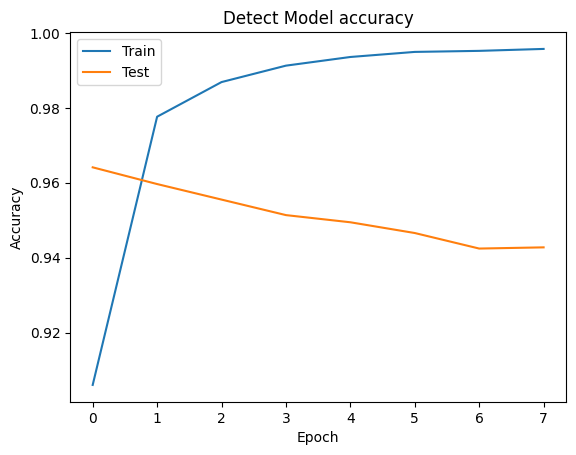

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(detect_model_history.history['accuracy'])
plt.plot(detect_model_history.history['val_accuracy'])
plt.title('Detect Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

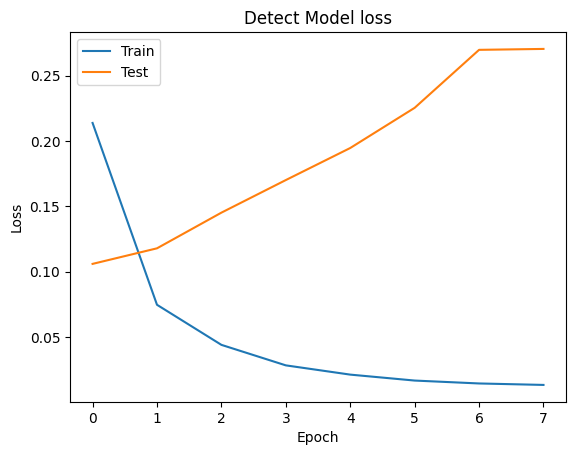

In [ ]:
# Plot training & validation loss values
plt.plot(detect_model_history.history['loss'])
plt.plot(detect_model_history.history['val_loss'])
plt.title('Detect Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

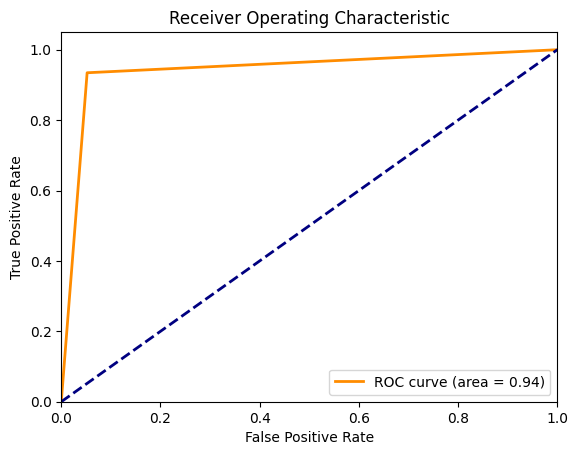

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_classes)

# Calculate ROC area under curve
roc_auc = roc_auc_score(y_true_classes, y_pred_classes)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


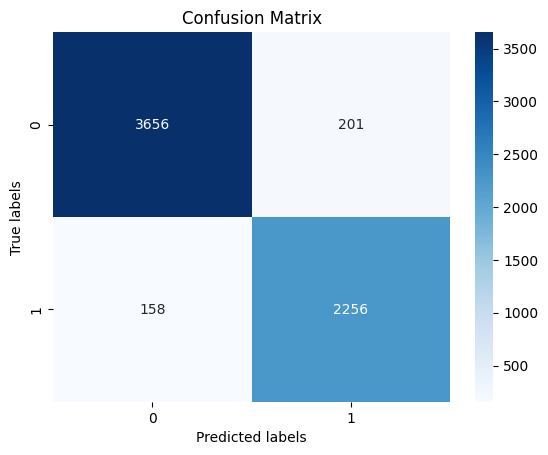

In [ ]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


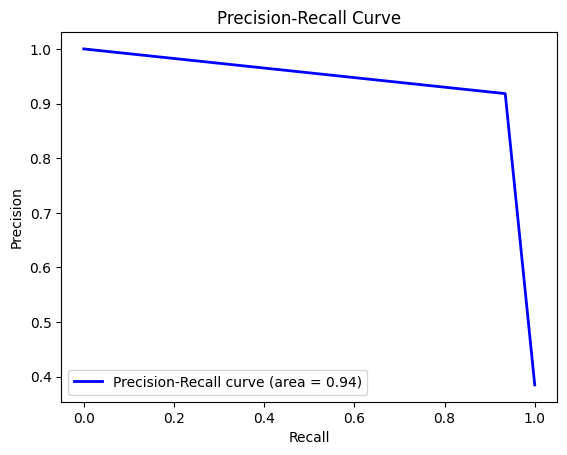

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true_classes, y_pred_classes)

# Calculate area under curve
auc_score = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



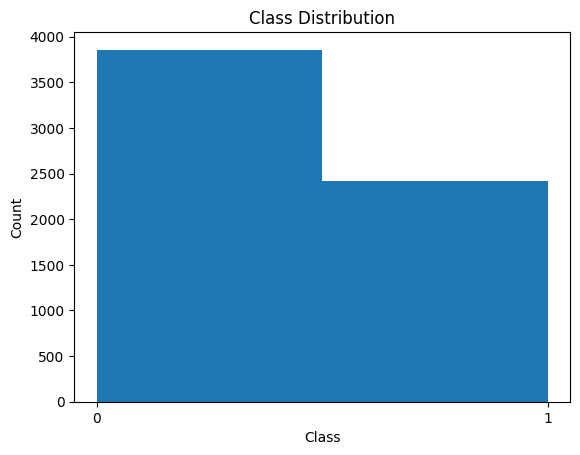

In [ ]:
plt.hist(y_true_classes, bins=2)
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

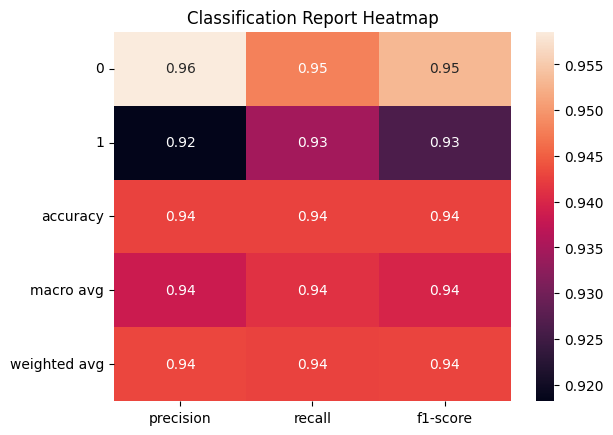

In [ ]:
import seaborn as sns

report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.title('Classification Report Heatmap')
plt.show()


# Mitigation

In [ ]:
import openpyxl

# Path to the input Excel file
input_excel_file = '/content/shufd_dup_miti_data_3000.xlsx'

# Path to the output text file
output_txt_file = 'test_data_new.txt'

# Load the Excel file
workbook = openpyxl.load_workbook(input_excel_file)
sheet = workbook.active

# Open the output text file
with open(output_txt_file, mode='w') as txt_file:
    for row in sheet.iter_rows(values_only=True):
        tweet, retweet = row
        # txt_file.write(f"{tweet}\t{retweet}\n")
        txt_file.write(f"{retweet}\t{tweet}\n")


In [ ]:
with open('/content/test_data_new.txt', 'r') as fp:
  data = fp.read().split('\n')

data[4]

'This culprit needs to be stopped.\tThis mf needs to be stopped.'

In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
# Download the file
import pathlib

# path_to_zip = tf.keras.utils.get_file(
#     'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
#     extract=True)

# path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'
path_to_file = pathlib.Path("/content/test_data_new.txt")

In [ ]:
import numpy as np

def load_data(path):
    with open(path, 'r', encoding='utf-8') as file:
        lines = file.readlines()
        pairs = [line.strip().split('\t') for line in lines]

        # Add this loop to check and handle cases where split result doesn't have two values
        cleaned_pairs = []
        for pair in pairs:
            if len(pair) == 2:
                cleaned_pairs.append(pair)
            else:
                print(f"Ignoring invalid pair: {pair}")

    context = np.array([context for target, context in cleaned_pairs])
    target = np.array([target for target, context in cleaned_pairs])

    return target, context


In [ ]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

The cashier was a rude cunt.


In [ ]:
print(target_raw[-1])

The cashier was really impolite.


In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:3])
  print()
  print(example_target_strings[:3])
  break

tf.Tensor(
[b'He bitched out of the deal last minute.'
 b'Everything look better with a bitch next to it'
 b'A loyal bitch from the burbs without daddy issues is like finding a holographic Mewtwo....sounding like me over there lol'], shape=(3,), dtype=string)

tf.Tensor(
[b'He backed out of the deal last minute.'
 b'Everything looks better with a friend next to it'
 b'A faithful partner from the suburbs without paternal upbringing issues is like discovering a rare Pok\xc3\x83\xc2\xa9mon card. ...sounding similar to me over there, LOL.'], shape=(3,), dtype=string)


In [ ]:
example_text = tf.constant('This sucks big time.')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'This sucks big time.'
b'This sucks big time.'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

This sucks big time.
[START] this sucks big time . [END]


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'a', 'to', 'you']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'the', 'a', 'to', 'you']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 32, 452, 59, 16, 5, 499, 201, 808, 4, 3],
 [2, 389, 143, 203, 22, 7, 14, 1475, 8, 41, 3],
 [2, 7, 375, 14, 73, 5, 4105, 459, 3869, 1564, 11, 33, 1645, 7, 3360, 2992,
  4, 4, 4, 4, 2314, 33, 25, 116, 127, 255, 3]                              ]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] he bitched out of the deal last minute . [END]'

Text(0.5, 1.0, 'Mask')

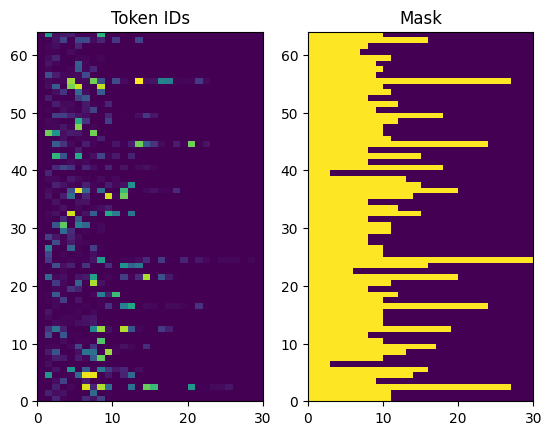

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[  2  32 452  59  16   5 499 201 808   4]

[   2   33 1987   65   15    6 1212  187  852    4]
[  33 1987   65   15    6 1212  187  852    4    3]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 25)
Encoder output, shape (batch, s, units): (64, 25, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 25, 256)
Target sequence, shape (batch, t, units): (64, 25, 256)
Attention result, shape (batch, t, units): (64, 25, 256)
Attention weights, shape (batch, t, s):    (64, 25, 25)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.0000001 , 1.        , 0.9999999 , 0.9999999 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

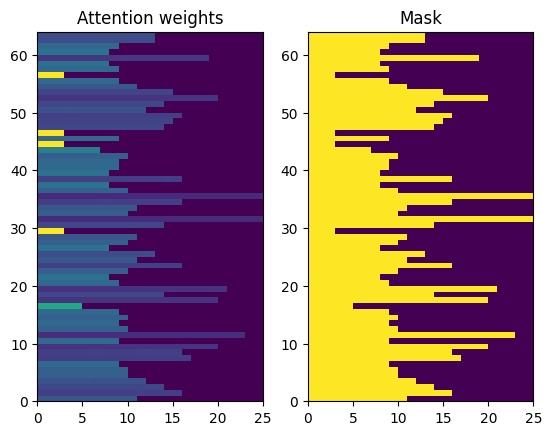

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self, context, x, state=None, return_state=False):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    # Ensure the state is correctly structured and matches what the GRU layer expects.
    # For a single GRU layer, the state should be a tensor of shape [batch_size, units].
    # For a bidirectional GRU, it would be [batch_size, 2 * units] if you're using the concatenation mode.
    # Here, I'm assuming a single GRU layer for simplicity. Adjust as necessary.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    # Ensure the state is correctly returned if requested.
    if return_state:
        return logits, state
    else:
        return logits


In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'decoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


encoder output shape: (batch, s, units) (64, 25, 256)
input target tokens shape: (batch, t) (64, 25)
logits shape shape: (batch, target_vocabulary_size) (64, 25, 4638)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'decoder' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    # Ensure the initial state for the GRU layer matches its expected shape.
    # Since you're using a bidirectional GRU in the Encoder, you might need to adjust this.
    # For a single GRU layer, the initial state should be [batch_size, units].
    # For a bidirectional GRU, it would be [batch_size, 2 * units] if you're using the concatenation mode.
    # Here, I'm assuming a single GRU layer for simplicity. Adjust as necessary.
    print(f'batch_size: {batch_size}')
    initial_state = self.rnn.get_initial_state(batch_size=batch_size)
    # initial_state = self.rnn.get_initial_state(inputs=None)
    return start_tokens, done, initial_state
    # return initial_state


In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature=0.0):
    logits, state = self(
        context, next_token,
        state=state,
        return_state=True)

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :] / temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state


In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

batch_size: 64


array([b'redsox simply lifestyle genuinely derek motto criticized want beyond showoff',
       b'photoshoot ratchet vision reserved lake due policies matt poop farmer',
       b'liking extremely messes rangel series politics spanish tinas exactly slice'],
      dtype=object)

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
mitigation_model = Translator(UNITS, context_text_processor, target_text_processor)

logits = mitigation_model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'decoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the m

Context tokens, shape: (batch, s, units) (64, 25)
Target tokens, shape: (batch, t) (64, 25)
logits, shape: (batch, t, target_vocabulary_size) (64, 25, 4638)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
mitigation_model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.442039, 'expected_acc': 0.00021561017680034498}

In [ ]:
mitigation_model.evaluate(val_ds, steps=20, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - loss: 8.1261 - masked_acc: 1.0881e-04 - masked_loss: 8.1261


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 7.739552021026611,
 'masked_acc': 0.0001075268883141689,
 'masked_loss': 7.739552021026611}

In [ ]:
history = mitigation_model.fit(
    train_ds.repeat(),
    epochs=8,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - loss: 6.5380 - masked_acc: 0.1255 - masked_loss: 6.5380 - val_loss: 4.6572 - val_masked_acc: 0.2590 - val_masked_loss: 4.6572
Epoch 2/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 3.9861 - masked_acc: 0.3742 - masked_loss: 3.9861 - val_loss: 3.8487 - val_masked_acc: 0.3732 - val_masked_loss: 3.8487
Epoch 3/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - loss: 2.1763 - masked_acc: 0.6130 - masked_loss: 2.1763 - val_loss: 3.5369 - val_masked_acc: 0.4423 - val_masked_loss: 3.5369
Epoch 4/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 0.9808 - masked_acc: 0.8271 - masked_loss: 0.9808 - val_loss: 3.4384 - val_masked_acc: 0.4709 - val_masked_loss: 3.4384
Epoch 5/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - loss: 0.3381 - masked_acc: 0.9522 - masked_loss: 0.3381 - val_loss: 3.5026 - val_masked_acc: 0.4884 - val_masked_loss: 3.5026
Epoch 6/8
100/100 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.1271 - masked_acc: 0.9847 - masked_los

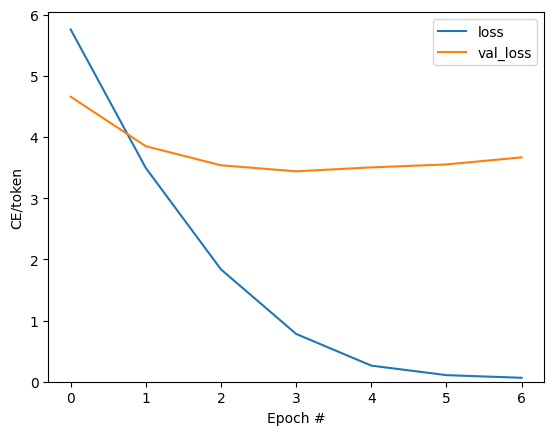

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

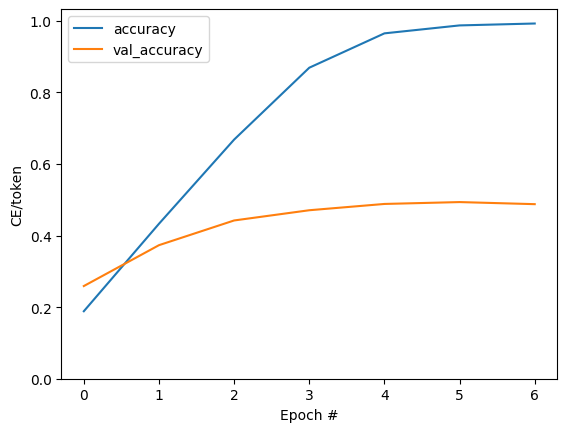

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = mitigation_model.translate(["Don't call me a pussy, I'm not afraid to fight back."])
result[0].numpy().decode()

batch_size: 1


'dont call me weak , im not afraid to fight back . '

In [ ]:
result = mitigation_model.translate(["She is a bitch."])
result[0].numpy().decode()

batch_size: 1


'she is a woman . '

In [ ]:
result = mitigation_model.translate(["The cashier is a rude cunt."])
result[0].numpy().decode()

batch_size: 1


'the cashier is really impolite . '

In [ ]:
result = mitigation_model.translate(["She is a cunt."])
result[0].numpy().decode()

batch_size: 1


'she is very fool . '

In [ ]:
result = mitigation_model.translate(["Don't be a cunt"])
result[0].numpy().decode()

batch_size: 1


'dont be very jerk '

In [ ]:
result = mitigation_model.translate(["Are you nigga"])
result[0].numpy().decode()

batch_size: 1


'are you jerk '

In [ ]:
result = mitigation_model.translate(["He is such a dick"])
result[0].numpy().decode()

batch_size: 1


'he is such a jerk '

In [ ]:
result = mitigation_model.translate(["Don't call me a pussy, I'm not afraid to fight back."])
result[0].numpy().decode()

batch_size: 1


'dont call me weak , im not afraid to fight back . '

## Detection, then mitigation

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Not for gradio

import numpy as np

def predict_profanity(text):
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

    predicted_probabilities = detect_model.predict(text_sequence_padded)
    predicted_class = np.argmax(predicted_probabilities)

    print(f'Predicted class: {predicted_class}')

    if predicted_class == 1:
        print("\nProfanity is 'NOT DETECTED' :)\n")
    else:
        print("\nProfanity 'DETECTED'!!!\n")
        mitigate_profanity(text)

def mitigate_profanity(text):
    result = mitigation_model.translate([text])
    cleaned_text = result[0].numpy().decode()
    print(f'\nMitigated text: {cleaned_text}')


In [ ]:
text = "Please leave this place."
predict_profanity(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: 1

Profanity is 'NOT DETECTED' :)



In [ ]:
text = "Please leave this fucking place."
predict_profanity(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class: 0

Profanity 'DETECTED'!!!

batch_size: 1

Mitigated text: please leave this place . 




---





---



## Gradio Interface

In [ ]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr

In [ ]:
import numpy as np

def mitigate_profanity_gradio(text):
    result = mitigation_model.translate([text])
    cleaned_text = result[0].numpy().decode()
    return cleaned_text

def predict_profanity_gradio(text):
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence_padded = pad_sequences(text_sequence, maxlen=max_length)

    predicted_probabilities = detect_model.predict(text_sequence_padded)
    predicted_class = np.argmax(predicted_probabilities)

    if predicted_class == 1:
        prediction = "Profanity is 'NOT DETECTED' :)"
    else:
        prediction = "Profanity 'DETECTED'!!!"
        prediction += f"\nMitigated text: {mitigate_profanity_gradio(text)}"

    return prediction


In [ ]:
iface = gr.Interface(
    fn=predict_profanity_gradio,
    inputs=gr.Textbox(lines=2, label="Enter your text here"),
    outputs="text",
    title="CivilityNet",
    description="Enter text to detect and mitigate profanity effectively.",
)

In [ ]:
iface.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://d7cc2d6c4597af50f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
batch_size: 1
1/1 ━━━━━━━━━━━━━━━━